In [1]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial 
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [2]:
import functools

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The sigma of the SDE. 
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The sigma of the SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)
  
sigma =  25.0

device = torch.device('cuda' if torch.cuda.is_available() else "mps" if torch.cuda.is_available() else 'cpu')

marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [3]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  #loss is MSE between estimated score and true score as per Song 2021 eq 7
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [11]:
###Sampler
import tqdm

def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           batch_size=64, 
                           num_steps=500, 
                           device='cuda', 
                           eps=1e-3):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns:
    Samples.    
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
  return mean_x

In [14]:
from torchvision import datasets, transforms, utils

def reporter(mean_x):
    """Callback function used for plotting images during training
    
    Args:
      mean_x: The generated samples from the Euler-Maruyama sampler.

    """

    # Number of samples to plot
    nsamples = 10

    # Get samples
    samples = mean_x[:nsamples].cpu().detach()

    # print(samples.shape)
    # print(samples)
    
    # Map pixel values back from [-1,1] to [0,1]
    samples = (samples+1)/2 
    samples = samples.clamp(0.0, 1.0)

    # Plot in grid
    grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
    plt.gca().set_axis_off()
    plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
    plt.show()   

Training Progress:   0%|          | 0/50 [00:00<?, ?epoch/s]

/var/folders/sk/6zwfz76x0z34qpjtwyy0r7y40000gn/T/ipykernel_77273/1203775058.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
/var/folders/sk/6zwfz76x0z34qpjtwyy0r7y40000gn/T/ipykernel_77273/1203775058.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
100%|██████████| 300/300 [00:04<00:00, 60.13it/s]


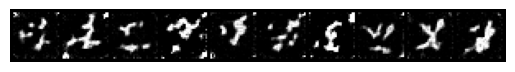

100%|██████████| 300/300 [00:04<00:00, 60.17it/s]:24:29, 105.61s/epoch, Average Loss=54.302528] 


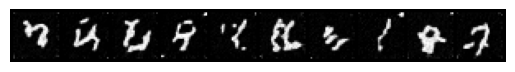

100%|██████████| 300/300 [00:05<00:00, 59.43it/s]:22:54, 108.15s/epoch, Average Loss=39.445105]


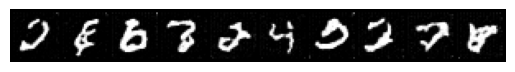

100%|██████████| 300/300 [00:04<00:00, 63.03it/s]:19:11, 108.00s/epoch, Average Loss=34.765415]


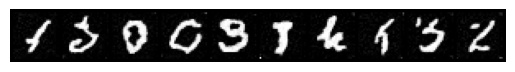

100%|██████████| 300/300 [00:04<00:00, 61.95it/s]:15:22, 107.67s/epoch, Average Loss=32.084226]


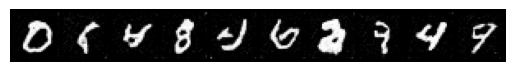

100%|██████████| 300/300 [00:04<00:00, 64.70it/s]1:11:32, 107.32s/epoch, Average Loss=30.946812]


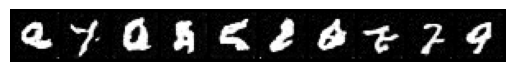

100%|██████████| 300/300 [00:04<00:00, 63.35it/s]1:07:53, 107.19s/epoch, Average Loss=29.900698]


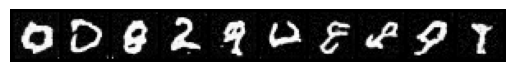

100%|██████████| 300/300 [00:04<00:00, 63.22it/s]1:04:25, 107.38s/epoch, Average Loss=28.665283]


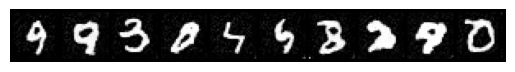

100%|██████████| 300/300 [00:04<00:00, 67.51it/s]1:00:33, 106.87s/epoch, Average Loss=28.421445]


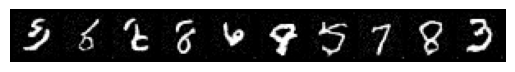

100%|██████████| 300/300 [00:04<00:00, 62.00it/s]56:54, 106.70s/epoch, Average Loss=27.879549]  


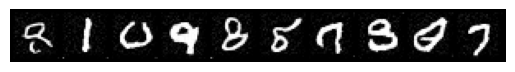

100%|██████████| 300/300 [00:04<00:00, 61.66it/s]53:28, 106.96s/epoch, Average Loss=27.339842]


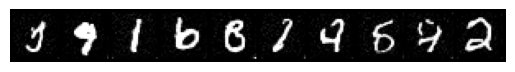

100%|██████████| 300/300 [00:04<00:00, 66.46it/s]49:28, 106.02s/epoch, Average Loss=27.150092]


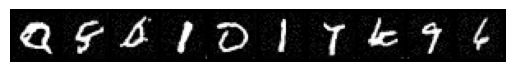

100%|██████████| 300/300 [00:04<00:00, 64.55it/s]45:51, 105.83s/epoch, Average Loss=26.972980]


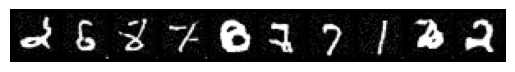

100%|██████████| 300/300 [00:04<00:00, 63.57it/s]42:27, 106.13s/epoch, Average Loss=26.614831]


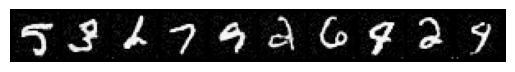

100%|██████████| 300/300 [00:04<00:00, 65.99it/s]39:11, 106.89s/epoch, Average Loss=26.299412]


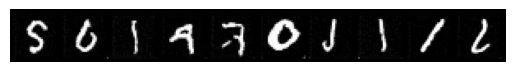

100%|██████████| 300/300 [00:04<00:00, 62.62it/s]35:43, 107.18s/epoch, Average Loss=26.463898]


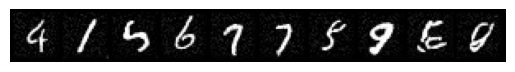

100%|██████████| 300/300 [00:04<00:00, 61.79it/s]32:04, 106.94s/epoch, Average Loss=25.877525]


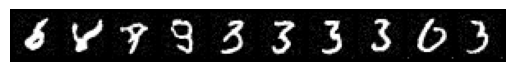

100%|██████████| 300/300 [00:04<00:00, 64.83it/s]1<42:03, 157.73s/epoch, Average Loss=26.000070]


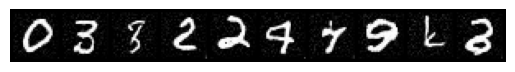

100%|██████████| 300/300 [00:04<00:00, 63.92it/s]1<30:26, 130.46s/epoch, Average Loss=25.577550]


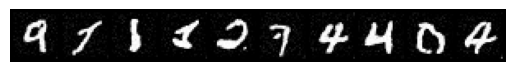

100%|██████████| 300/300 [00:04<00:00, 62.70it/s]0<23:23, 116.97s/epoch, Average Loss=25.686993]


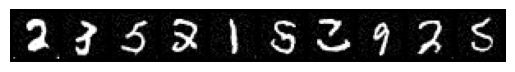

100%|██████████| 300/300 [00:04<00:00, 64.89it/s]9<18:24, 110.41s/epoch, Average Loss=25.483505]


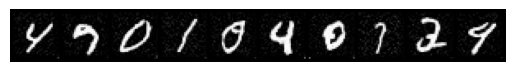

100%|██████████| 300/300 [00:07<00:00, 42.82it/s]9<14:19, 107.39s/epoch, Average Loss=25.465472]


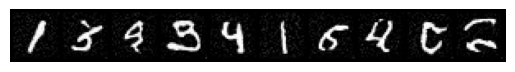

100%|██████████| 300/300 [00:04<00:00, 62.26it/s]3<10:40, 106.79s/epoch, Average Loss=25.160493]


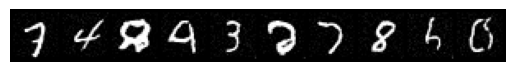

100%|██████████| 300/300 [00:04<00:00, 63.65it/s]2<07:01, 105.50s/epoch, Average Loss=25.286398]


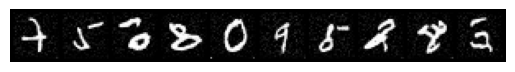

100%|██████████| 300/300 [00:04<00:00, 63.84it/s]2<03:30, 105.05s/epoch, Average Loss=25.148467]


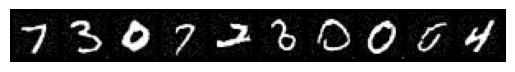

Training Progress: 100%|██████████| 50/50 [1:31:42<00:00, 110.05s/epoch, Average Loss=25.074354]


In [15]:
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from tqdm import trange  # Import tqdm for both epoch and batch progress
import matplotlib.pyplot as plt

# Assuming ScoreNet, loss_fn, marginal_prob_std_fn, Euler_Maruyama_sampler, reporter, device are defined elsewhere

# Initialize the model
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))

# score_model.load_state_dict(torch.load('continuous_diffusion_ckpt.pth'))
score_model = score_model.to(device)

# Training parameters
n_epochs = 50
batch_size = 64
lr = 1e-3
sampler_num_steps = 100

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x - 0.5) * 2.0),                # Map from [0,1] -> [-1, 1]
    #transforms.Lambda(lambda x: x.flatten())
])

# Load the MNIST dataset
dataloader_train = DataLoader(
    MNIST('./mnist_data', download=True, train=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)

# Initialize the optimizer
optimizer = Adam(score_model.parameters(), lr=lr)

# Initialize the epoch progress bar
tqdm_epoch = trange(n_epochs, desc='Training Progress', unit='epoch')

for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    
    # Optionally, add a nested progress bar for batches
    for x, y in dataloader_train:
        x = x.to(device)
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item() * x.size(0)
        num_items += x.size(0)
    
    # Calculate the average loss for the epoch
    average_loss = avg_loss / num_items
    
    # Display using sampler every 2 epochs (adjusted from 10 to match your condition)
    if epoch % 2 == 0:
        sampler = Euler_Maruyama_sampler(
            score_model, marginal_prob_std_fn, diffusion_coeff_fn, 
            batch_size=16, num_steps=sampler_num_steps, device=device
        ) 
        # Show the generated images inline
        reporter(sampler)
    
    # Update the checkpoint after each epoch of training
    torch.save(score_model.state_dict(), 'continuous_diffusion_ckpt.pth')
    
    # Update the progress bar with the average loss
    tqdm_epoch.set_postfix({'Average Loss': f'{average_loss:.6f}'})
